# Imports

In [1]:
import numpy as np
import pandas as pd
from data_processing.csv_reader import CSVReader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from time_series_processing.differencing import Differencer
from data_processing.feature_generation import FeatureGenerator
from environments.stock_env import StockEnvironment
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, DotProduct
from feature_selection.recursive_feature_selection import RecursiveFeatureSelection
import os
import sys

sys.path.append("C:/Users/YuweiZhu/OneDrive - Alloyed/Documents/Market-Prediction-Research/terminal")
sys.path.append("C:/Users/YuweiZhu/OneDrive - Alloyed/Documents/Market-Prediction-Research")

from environments.reinforcement_learning_env import ReinforcementLearningEnvironment

In [2]:
%reload_ext autoreload
%autoreload 2

# Main

In [120]:
path = "../raw_data/AAPL.csv"
csvr = CSVReader(path=path)


csvr.get_properties()
df = csvr.get_df()[-3000:]

         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099449  469033600
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094261  175884800
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087343  105728000
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089504   86441600
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092099   73449600


In [121]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
7809,2011-11-23,13.375357,13.422857,13.102857,13.106786,11.124993,428271200
7810,2011-11-25,13.157857,13.255357,12.975714,12.984643,11.021320,254760800
7811,2011-11-28,13.298214,13.454286,13.226071,13.432857,11.401764,346413200
7812,2011-11-29,13.422857,13.529643,13.221429,13.328571,11.313245,375855200
7813,2011-11-30,13.617500,13.652857,13.510714,13.650000,11.586071,405938400
...,...,...,...,...,...,...,...
10804,2023-10-20,175.309998,175.419998,172.639999,172.880005,172.880005,64189300
10805,2023-10-23,170.910004,174.009995,169.929993,173.000000,173.000000,55980100
10806,2023-10-24,173.050003,173.669998,171.449997,173.440002,173.440002,43816600
10807,2023-10-25,171.880005,173.059998,170.649994,171.100006,171.100006,57157000


In [122]:
fg = FeatureGenerator(df, task="custom")
fg._create_classes(period=7)
fg.apply_exponential_moving_average(periods=[3,5,7,14,30,100,200])
fg.apply_bollinger_bands(period=7)
fg.apply_moving_cumulation(periods=[3,5,7,14,30,100,200])
fg.apply_momentum(periods=[3,5,7,14,30,100,200])
fg.apply_moving_averages(periods=[3,5,7,14,30,100,200])
fg.apply_MACD_indicator()
fg.apply_relative_strength_index()

c:\Users\YuweiZhu\OneDrive - Alloyed\Documents\Market-Prediction-Research\terminal\data_processing\feature_generation.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.drop(columns=[col], inplace=True)
c:\Users\YuweiZhu\OneDrive - Alloyed\Documents\Market-Prediction-Research\terminal\data_processing\feature_generation.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.drop(columns=[col], inplace=True)
c:\Users\YuweiZhu\OneDrive - Alloyed\Documents\Market-Prediction-Research\terminal\data_processing\feature_generation.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [123]:
training_features = fg.training_features + ["Adj Close", "Volume"]
training_features

['3 day ema',
 '5 day ema',
 '7 day ema',
 '14 day ema',
 '30 day ema',
 '100 day ema',
 '200 day ema',
 '7 day simple moving average',
 '7 day moving deviation',
 '7 day lower bband',
 '7 day upper bband',
 '3 day cumulation',
 '5 day cumulation',
 '7 day cumulation',
 '14 day cumulation',
 '30 day cumulation',
 '100 day cumulation',
 '200 day cumulation',
 '3 day momentum',
 '5 day momentum',
 '7 day momentum',
 '14 day momentum',
 '30 day momentum',
 '100 day momentum',
 '200 day momentum',
 '3 day simple moving average',
 '5 day simple moving average',
 '7 day simple moving average',
 '14 day simple moving average',
 '30 day simple moving average',
 '100 day simple moving average',
 '200 day simple moving average',
 '26 day ema',
 '12 day ema',
 '26/12 macd',
 '26/12 macd 9 day signal',
 'Adj Close',
 'Volume']

In [124]:
data = fg.df.dropna()
data

,Adj Close,Volume,Next Close,Difference,Profit,3 day ema,5 day ema,7 day ema,14 day ema,30 day ema,...,26 day ema,12 day ema,26/12 macd,26/12 macd 9 day signal,returns,gains,loss,14 day average gains,14 day average loss,14 day RSI
8009,20.111210,503983200,20.211063,0.099853,0.0,20.251903,20.318289,20.336187,20.225209,19.756010,...,19.870774,20.273687,0.402913,0.479699,-0.003244,0.000000,0.003244,0.005077,0.004510,52.956228
8010,20.391296,712233200,20.252777,-0.138519,0.0,20.321600,20.342625,20.349965,20.247354,19.796996,...,19.909331,20.291780,0.382449,0.460249,0.013927,0.013927,0.000000,0.004677,0.004510,50.908096
8011,20.792856,598360000,20.548998,-0.243858,0.0,20.557228,20.492702,20.460687,20.320088,19.861245,...,19.974777,20.368869,0.394092,0.447017,0.019693,0.019693,0.000000,0.006083,0.003843,61.282131
8012,21.045544,600474000,20.404701,-0.640843,1.0,20.801386,20.676983,20.606902,20.416815,19.937652,...,20.054093,20.472973,0.418880,0.441390,0.012153,0.012153,0.000000,0.006888,0.003843,64.184645
8013,21.304327,398031200,20.588579,-0.715748,1.0,21.052856,20.886097,20.781258,20.535150,20.025824,...,20.146703,20.600873,0.454170,0.443946,0.012296,0.012296,0.000000,0.006424,0.003843,62.567353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10797,179.800003,47551100,173.750000,-6.050003,1.0,178.838485,177.905885,177.175401,176.198617,177.040896,...,176.719630,176.298216,-0.421415,-1.470339,0.007904,0.007904,0.000000,0.005525,0.003101,64.046914
10798,180.710007,56743100,172.399994,-8.310013,1.0,179.774246,178.840592,178.059053,176.800136,177.277613,...,177.015214,176.976953,-0.038261,-1.183923,0.005061,0.005061,0.000000,0.005533,0.003101,64.081619
10799,178.850006,51427100,173.660004,-5.190002,1.0,179.312126,178.843730,178.256791,177.073452,177.379057,...,177.151124,177.265115,0.113990,-0.924340,-0.010293,0.000000,0.010293,0.005006,0.003836,56.612100
10800,178.720001,52517000,174.910004,-3.809997,1.0,179.016064,178.802487,178.372593,177.292992,177.465570,...,177.267337,177.488943,0.221606,-0.695151,-0.000727,0.000000,0.000727,0.005006,0.002217,69.304740


In [125]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from feature_selection.permutation_feature_importance import PermutationFeatureImportance
from sklearn.svm import SVC
from copy import deepcopy

In [126]:
pfi = PermutationFeatureImportance(
    data, 
    deepcopy(training_features), 
    "Profit",
    model = SVC
)

pfi.calculate()


{'importances_mean': array([-0.00017889,  0.00125224,  0.00071556, -0.00035778, -0.00071556,
        -0.00232558,  0.00357782,  0.00161002,  0.01323792, -0.00017889,
         0.0019678 , -0.00214669, -0.00071556,  0.00161002,  0.00035778,
        -0.00017889, -0.00089445,  0.00053667,  0.00447227,  0.00769231,
         0.01878354,  0.01592129,  0.00071556, -0.00089445,  0.0059034 ,
        -0.00214669, -0.00071556,  0.00161002,  0.00035778, -0.00017889,
        -0.00089445,  0.00053667, -0.00053667, -0.00035778,  0.03864043,
         0.0273703 ,  0.00071556,  0.        ]),
 'importances_std': array([0.00148598, 0.00179783, 0.00242659, 0.00208621, 0.00143113,
        0.00081978, 0.00277137, 0.00218364, 0.00847422, 0.00343638,
        0.00218364, 0.00175277, 0.00199204, 0.00218364, 0.00192671,
        0.00148598, 0.00120004, 0.00212421, 0.00549926, 0.00486964,
        0.00680021, 0.00334196, 0.00519708, 0.00684711, 0.0099939 ,
        0.00175277, 0.00199204, 0.00218364, 0.00192671, 0.001

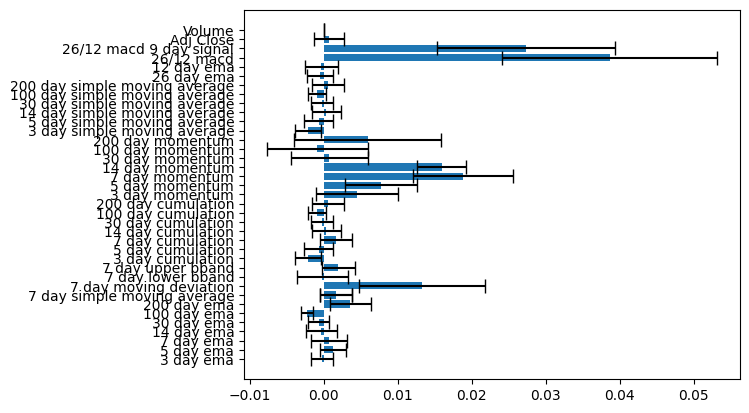

In [127]:
pfi.plot()

In [128]:
rfe = RecursiveFeatureSelection(data, 
                                deepcopy(training_features), 
                                "Profit", 
                                1,
                                model=SVC)

In [129]:
res = rfe.run()
res

100%|██████████| 37/37 [02:22<00:00,  3.84s/it]


,features_used,removed,scores
0,"[5 day ema, 7 day ema, 14 day ema, 30 day ema,...",3 day ema,0.581395
1,"[5 day ema, 7 day ema, 14 day ema, 30 day ema,...",7 day upper bband,0.579606
2,"[5 day ema, 7 day ema, 14 day ema, 30 day ema,...",200 day ema,0.579606
3,"[5 day ema, 7 day ema, 14 day ema, 30 day ema,...",30 day cumulation,0.579606
4,"[5 day ema, 7 day ema, 14 day ema, 100 day ema...",30 day ema,0.579606
5,"[5 day ema, 7 day ema, 14 day ema, 100 day ema...",100 day momentum,0.579606
6,"[5 day ema, 7 day ema, 14 day ema, 100 day ema...",30 day simple moving average,0.579606
7,"[5 day ema, 7 day ema, 14 day ema, 100 day ema...",7 day moving deviation,0.579606
8,"[5 day ema, 7 day ema, 14 day ema, 100 day ema...",200 day momentum,0.579606
9,"[5 day ema, 7 day ema, 14 day ema, 100 day ema...",Adj Close,0.577818


In [130]:
res.to_csv("results.csv")

In [131]:
X = data[['5 day momentum', '7 day simple moving average', '14 day simple moving average', '26/12 macd', 'Volume']].to_numpy()
y = data["Profit"].to_numpy()

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, shuffle=False, test_size=0.2)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [132]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.554561717352415

In [133]:
gpc = GaussianProcessClassifier()
gpc.fit(X_train, y_train)
gpc.score(X_test, y_test)

0.5134168157423972

In [144]:
svc = SVC(probability=True)
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.6440071556350626

In [145]:
from sklearn.metrics import precision_score, recall_score

In [180]:
y_pred = svc.predict_proba(X_test)
y_pred = (y_pred[:, 1] >= 0.5).astype(int)

In [181]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,

In [182]:
precision_score(y_test, y_pred)

0.654320987654321

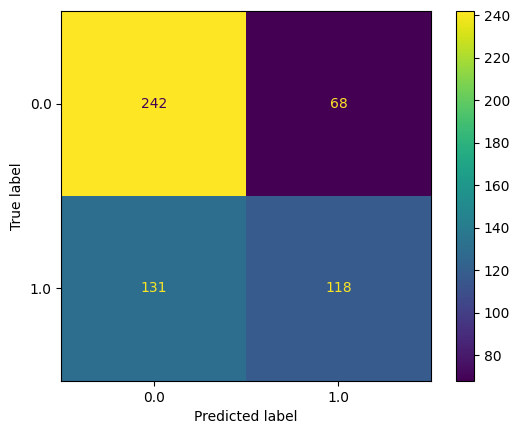

In [161]:
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=svc.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()

In [108]:
import plotly.express as px
import plotly.graph_objects as go

In [184]:
price = data["Adj Close"]
length = len(price)
split = round(0.8*length)

fig = px.scatter(x=range(len(price[split:])), y=price[split:], color=y_pred)
fig.show()

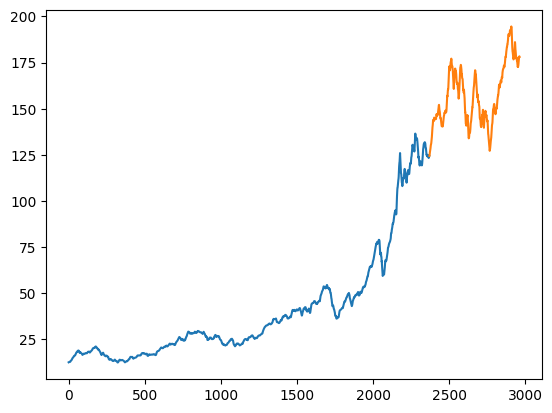

In [177]:
price = X[:, 0]

length = len(price)
split = round(0.8*length)
plt.plot(range(split), price[:split])
plt.plot(range(split, length), price[split:])

In [137]:
res

,features_used,removed,scores
0,[14 day momentum],5 day momentum,0.715
1,[14 day momentum],3 day momentum,0.715
2,[14 day momentum],7 day momentum,0.725
3,[14 day momentum],3 day moving average,0.725
4,[14 day momentum],5 day moving average,0.730
5,[14 day momentum],3 day ema,0.735
6,[14 day momentum],7 day moving average,0.735
7,[14 day momentum],14 day moving average,0.735
8,[14 day momentum],30 day moving average,0.735
9,[14 day momentum],5 day ema,0.735


In [153]:
X_train, X_test, y_train, y_test = fg.create_modelling_data(features=["Adj Close", "Volume"], target="Profit")

In [154]:
fg.training_features

['7 day ema',
 '14 day ema',
 '30 day ema',
 '7 day moving average',
 '7 day lower bband',
 '7 day upper bband',
 '3 day cumulation',
 '5 day cumulation',
 '7 day cumulation',
 '14 day cumulation',
 '30 day cumulation',
 '14 day momentum',
 '30 day momentum',
 '3 day cumulation',
 '5 day cumulation',
 '7 day cumulation',
 '14 day cumulation',
 '30 day cumulation']

In [199]:
# gpc = GaussianProcessClassifier()
# gpc.fit(X_train, y_train)
gpc.score(X_test, y_test)

0.6526138279932546

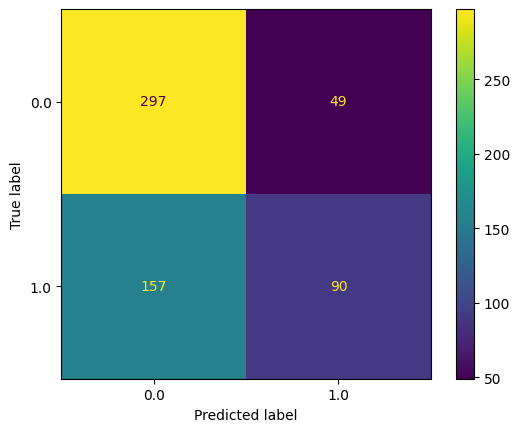

In [198]:
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay

y_pred = gpc.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=gpc.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gpc.classes_)
disp.plot()

In [6]:
from sklearn.metrics import r2_score
y_pred = gpc.predict(X_test)
r2_score(y_test, y_pred)

-0.44107291924668135

In [39]:
df["Next Close"] = df["Close"].shift(1)

In [40]:
df["Difference"] = df["Close"] - df["Next Close"]

In [41]:
df["Profit"] = (df["Difference"] > 0).astype(int)

In [42]:
df = df.drop([0])

In [43]:
df = find_recent_trends(df)

In [45]:
df = df.dropna()
df

,Date,Open,High,Low,Close,Adj Close,Volume,Next Close,Difference,Profit,Last 2 days,Last 7 days,Last 30 days,Last 100 days
100,1981-05-07,0.123884,0.124442,0.123884,0.123884,0.095991,9363200,0.122210,0.001674,1,1.0,2.0,11.0,42.0
101,1981-05-08,0.125000,0.125558,0.125000,0.125000,0.096855,7907200,0.123884,0.001116,1,2.0,3.0,12.0,43.0
102,1981-05-11,0.122768,0.122768,0.122210,0.122210,0.094694,11939200,0.125000,-0.002790,0,1.0,2.0,12.0,43.0
103,1981-05-12,0.122210,0.123884,0.122210,0.122210,0.094694,4256000,0.122210,0.000000,0,0.0,2.0,12.0,42.0
104,1981-05-13,0.122210,0.123326,0.121652,0.121652,0.094261,4905600,0.122210,-0.000558,0,0.0,2.0,12.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10804,2023-10-20,175.309998,175.419998,172.639999,172.880005,172.880005,64189300,175.460007,-2.580002,0,0.0,1.0,15.0,53.0
10805,2023-10-23,170.910004,174.009995,169.929993,173.000000,173.000000,55980100,172.880005,0.119995,1,1.0,1.0,15.0,54.0
10806,2023-10-24,173.050003,173.669998,171.449997,173.440002,173.440002,43816600,173.000000,0.440002,1,2.0,2.0,16.0,54.0
10807,2023-10-25,171.880005,173.059998,170.649994,171.100006,171.100006,57157000,173.440002,-2.339996,0,1.0,2.0,16.0,53.0


In [46]:
X = df[["Open", "High", "Low", "Close", "Volume", "Last 2 days", "Last 7 days", "Last 30 days", "Last 100 days"]]
y = df["Profit"]

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
X_train

array([[-0.47283795, -0.47244167, -0.47293075, ...,  0.38921156,
         0.37390384,  0.22373285],
       [ 0.90294628,  0.89625522,  0.90826908, ...,  1.15135452,
         1.41809624,  1.06521117],
       [-0.47285096, -0.47265206, -0.47283855, ..., -0.3729314 ,
        -0.32222442,  0.22373285],
       ...,
       [-0.48023891, -0.48013208, -0.4802607 , ...,  0.38921156,
        -0.32222442, -1.96411078],
       [-0.47371951, -0.4735623 , -0.4739361 , ...,  0.38921156,
         0.72196797,  0.05543718],
       [-0.48117529, -0.48107129, -0.48117988, ..., -1.89721732,
        -2.41060922, -1.45922379]])

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay

In [55]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)
y_pred = rfr.predict(X_test)

r2_score(y_test, y_pred)

0.518835435076443

In [51]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
lr.score(X_test, y_test)

0.7894491129785247

In [52]:
mse = lambda x, y : sum((x - y)**2)

avg = np.array([0.5]*len(y_pred))

1 - mse(y_pred, y_test)/mse(avg, y_test)

0.15779645191409897

In [22]:
def threshold(y_pred):

    for i in range(len(y_pred)):
        y_pred[i] = int(y_pred[i] >= 0.5)

    return y_pred

In [27]:
r2_score(y_test, y_pred)

-0.582410301319767

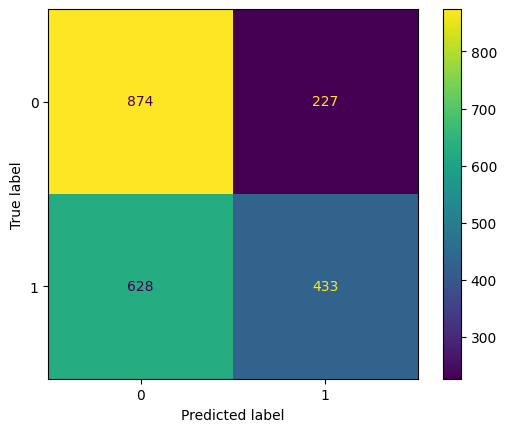

In [28]:
cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()